In [71]:
.libPaths(c(.libPaths(),'/usr/local/lib/R/site-library/'))
.libPaths(c(.libPaths(),'/usr/lib/R/library/'))
.libPaths(c(.libPaths(),'/home/david/R/x86_64-pc-linux-gnu-library/3.4'))
library(ggplot2)
library(cluster)
library(reshape2)
#source('~/projects/assembly17/run-ni-stv/tmpfunctions.R')
source('~/projects/assembly17/run-ni-stv/other_avr_functions.R')
library(circlize)
library(dplyr)
library(corrplot)

In [5]:
votes <- read.csv('~/Documents/sample_vote.csv', header=FALSE, stringsAsFactors=FALSE)
tra_votes <- as.data.frame(t(votes[,2:ncol(votes)]))
candidates <- votes[,1]
tra_votes <- tra_votes[sample(seq(nrow(tra_votes))), ]  #randomise order
names(tra_votes) <- candidates
row.names(tra_votes) <- paste('b',seq(nrow(tra_votes)),sep='')

### Headlines

In [6]:
cat(sprintf('Turnout was %.0f%% (%i/32)\n', nrow(tra_votes)*100/32, nrow(tra_votes)))

Turnout was 22% (7/32)


In [7]:
#The vote in full:
tra_votes

,Dinner,Bowling,Avoca,Board,Escape,Laser
b1,2,6,1,5,4,3
b2,1,3,6,5,2,4
b3,2,5,4,1,3,6
b4,4,1,5,2,3,6
b5,2,5,1,3,6,4
b6,1,2,5,4,6,3
b7,4,1,3,5,6,2


In [8]:
first_preferences <- apply(tra_votes,2,function(r) sum(r==1))
sort(first_preferences, decreasing = TRUE)

Dinner Bowling   Avoca   Board  Escape   Laser 
      2       2       2       1       0       0

Assign 5 points for first preference, 4 for second...0 for sixth, and sum:

In [109]:
apply(6-tra_votes, 2, sum)

Dinner Bowling   Avoca   Board  Escape   Laser 
     26      19      17      17      12      14

In [ ]:
#TODO combine into plot?

### Transfers

We can look at what actually happened in 

In [9]:
transfers <- readRDS('~/Documents/sample_transfer_matrix.rds')
transfers

,Avoca,Dinner,Board,Laser,Bowling,Escape
Board,0,1,NA,NA,0,NA
Avoca,NA,1,NA,NA,0,NA
Dinner,NA,NA,NA,NA,1,NA


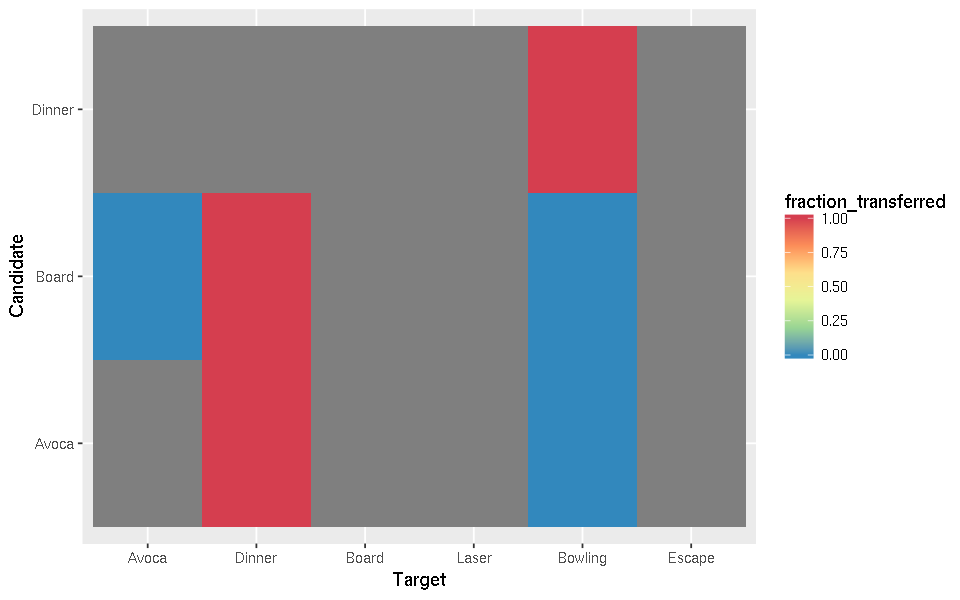

In [65]:
transfers_aug <- cbind(data.frame(candidate=row.names(transfers)), transfers)
transfers_aug <- melt(transfers_aug, id.vars='candidate')
names(transfers_aug) <- c('Candidate','Target','fraction_transferred')
#print(transfers_aug)
options(repr.plot.width=8, repr.plot.height=5)
ggplot(transfers_aug,aes(Target,Candidate)) + geom_tile(aes(fill=fraction_transferred)) +
    scale_fill_distiller(palette='Spectral',direction=-1)

Or better, we can measure what every candidate would have transferred to if given the opportunity, by looking at the next preference in each ballot. This is a bit inexact due to the different options available to transfer to within each ballot. Here I'm ignoring the 5 to 6 transfers (where there is no other option left), and counting all other transfers as  a success (1) for the candidate chosen next in the ballot, and a failure (0) for all other options that were available but not transferred to. Then group by 'from' and 'to'. This leads to fractions that can sum to more than 1 for a given 'from', but this is automatically normalised by the chord plot below.

In [89]:
#tra_votes
transfers_full <- data.frame()
for (b in seq(7)) {
    for (i in seq(5)) {
        from <- names(tra_votes)[which(tra_votes[b,]==i)]
        left <- names(tra_votes)[which(tra_votes[b,]>i)]
        to <- names(tra_votes)[which(tra_votes[b,]==i+1)]
        if (length(left) > 1) {
            #cat(b,i,from,'transferring, choice of',left,', went to',to,'\n')
            for (cand in left) {
                val <- ifelse(cand==to, 1, 0)
                transfers_full <- rbind(transfers_full,
                                       data.frame(from=from,to=cand,val=val))
            }
        }
        
    }
}
transfers_full <- transfers_full %>% group_by(from,to) %>% summarise(fraction_transferred=mean(val))

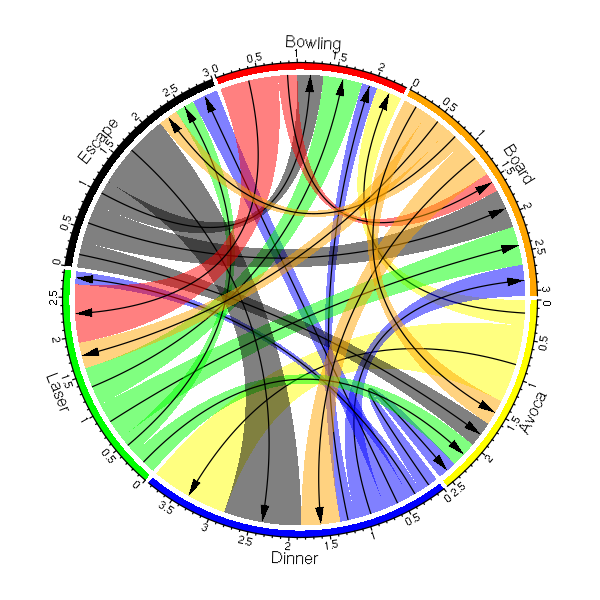

In [90]:
#transfers_aug_fill <- transfers_aug
#transfers_aug_fill[is.na(transfers_aug_fill)] <- 0
#chordDiagram(transfers_synth, directional=1, direction.type = 'arrows')
#print(subset(transfers_full,fraction_transferred>0))
options(repr.plot.width=5, repr.plot.height=5)
grid.col <- c(Avoca='yellow',Dinner='blue',Laser='green',Board='orange',Escape='black',Bowling='red')
chordDiagram(transfers_full, directional=1, direction.type = 'arrows', grid.col=grid.col)
#transfers_aug_fill

Plain old correlations show WHAT**

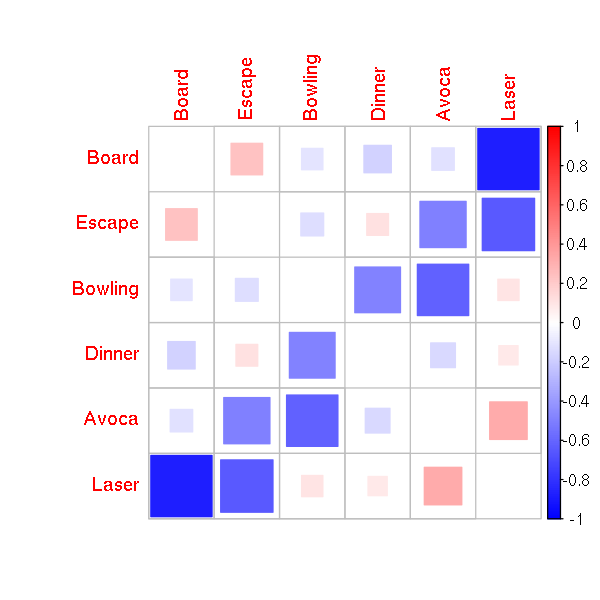

In [91]:
corrplot(cor(tra_votes),method='square',diag=FALSE,order='FPC',
        col=colorRampPalette(c("blue","white","red"))(200))

### Clustering

In [ ]:
#Most appropriate number of clusters

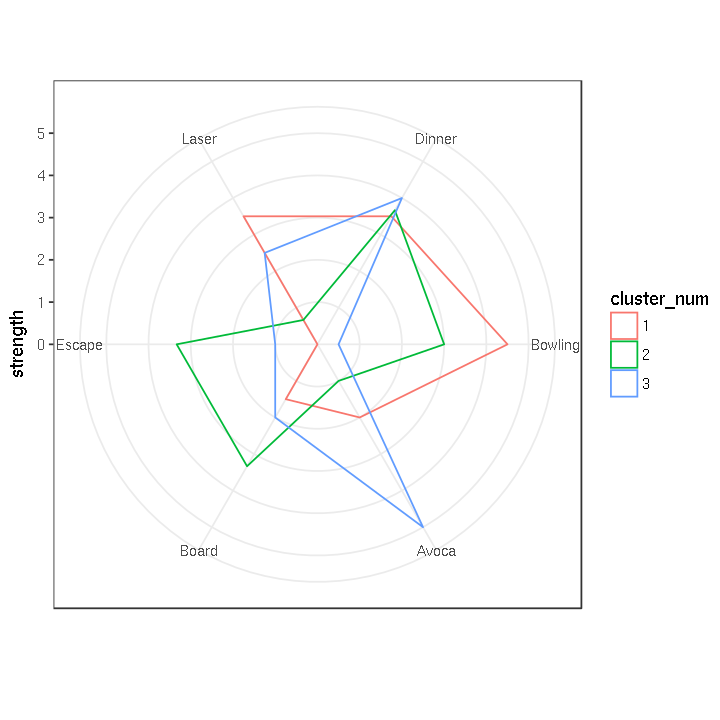

In [106]:
options(repr.plot.width=6, repr.plot.height=6)

cluster_centroids <- melt(kmeans(6-tra_votes,3)$centers)
names(cluster_centroids) <- c('cluster_num','candidate','strength')
cluster_centroids$cluster_num <- factor(cluster_centroids$cluster_num)
ggplot(cluster_centroids) + 
    geom_polygon(aes(candidate,strength,colour=cluster_num,group=cluster_num),fill=NA) +
    coord_polar() +
    theme_bw() + labs(x='')
#TODO reorder levels to match order of cluster 1
#kmeans(tra_votes,3)$centers

In [ ]:
#If ran STV on each of the clusters, winner should be as expected from above

Clustering in terms of the candidates:

In [104]:
print(votes)
kmeans(votes[,2:8],2)

       V1 V2 V3 V4 V5 V6 V7 V8
1  Dinner  2  2  4  1  1  2  4
2 Bowling  5  5  1  3  2  6  1
3   Avoca  1  4  5  6  5  1  3
4   Board  3  1  2  5  4  5  5
5  Escape  6  3  3  2  6  4  6
6   Laser  4  6  6  4  3  3  2


K-means clustering with 2 clusters of sizes 3, 3

Cluster means:
        V2 V3 V4       V5 V6 V7 V8
1 2.333333  4  5 3.666667  3  2  3
2 4.666667  3  2 3.333333  4  5  4

Clustering vector:
[1] 1 2 1 2 2 1

Within cluster sum of squares by cluster:
[1] 39.33333 43.33333
 (between_SS / total_SS =  32.5 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

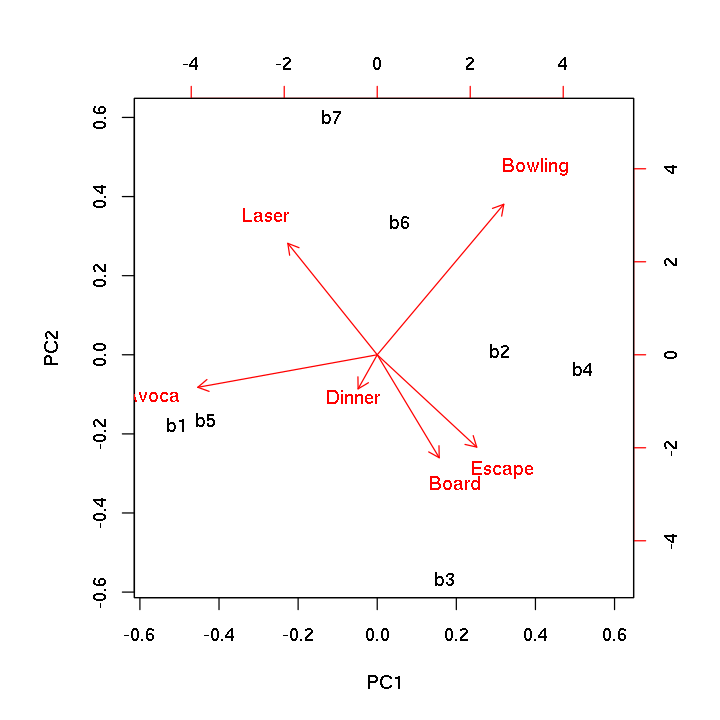

In [111]:
#Dim reduction? Can do for ballots, placing each on a 2d grid.
#  e.g. to left means 'how Avoca' you are, up means 'how Laser/Bowling'
biplot(prcomp(6-tra_votes))

In [ ]:
#TODO: try grouping by M/F? Old vs new?

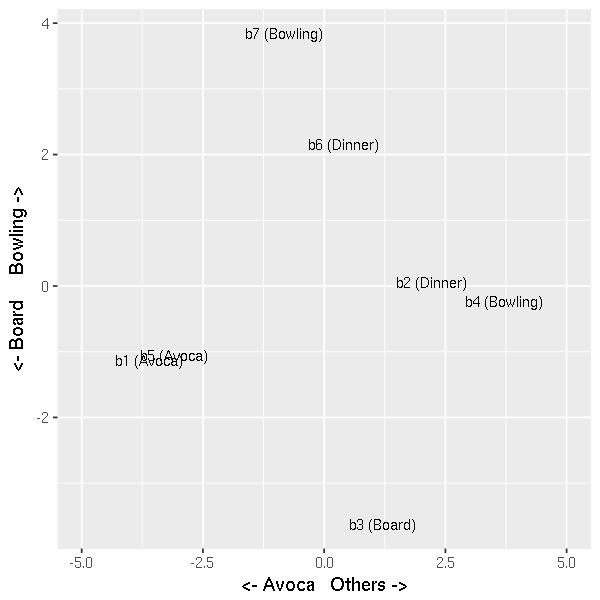

In [133]:
#TODO or can plot nicely with ggplot and label ballots by first pref, and describe axis meanings
options(repr.plot.width=5, repr.plot.height=5)
fp_labels <- as.character(apply(tra_votes, 1, function(r) names(tra_votes)[which(r==1)]))
fp_labels <- paste0(row.names(tra_votes),' (',fp_labels,')')
ggplot(data.frame(prcomp(6-tra_votes)$x)) + #geom_point(aes(PC1,PC2)) + 
    geom_text(aes(PC1,PC2,label=fp_labels),size=3) +
    labs(x='<- Avoca   Others ->', y='<- Board     Bowling ->') +
    xlim(-5,5) 
#TODO hide tick values

[1] "Dinner"  "Bowling" "Avoca"   "Board"   "Escape"  "Laser"  


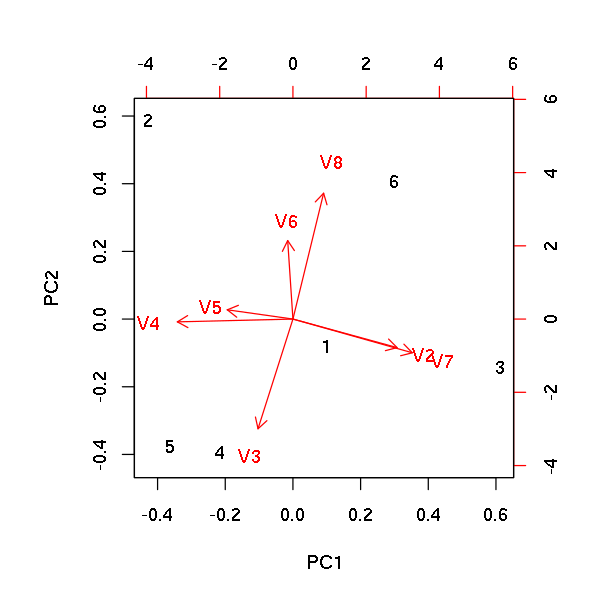

In [137]:
#Dim reduction on candidates is not so interesting
#e.g. right is now 'how V2,V7' the activity is
print(votes$V1)
biplot(prcomp(6-votes[,2:ncol(votes)]))